In [1]:
import numpy as np, matplotlib.pyplot as plt, glob, os, itertools, \
    skimage.segmentation as segm, networkx as nx, simplification.cutil as simpl, \
    scipy.ndimage as ndimage, matplotlib.colors as mplcol, matplotlib.cm as cm
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm_notebook as tqdm
import shapely.ops, shapely.geometry as geom
from skimage.measure import label

#### Set color scheme

In [2]:
COLORS = [
    (0, 0, 0),
    (230, 159, 0),
    (86, 180, 233),
    (0, 158, 115),
    (240, 228, 66),
    (0, 114, 178),
    (213, 94, 0),
    (204, 121, 167),
    (204, 200, 167),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
    (0, 0, 0),
]
COLORS = [mplcol.rgb2hex(np.array(x) / 255.0) for x in COLORS]

### Specify data files to display

In [3]:
fnameP = 'Y:/wavelet/rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd/'
fnameP+= 'rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameP = '\\\\?\\' + fnameP.replace('/', '\\')

fnameA = 'Y:/wavelet/rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd/'
fnameA+= 'rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
fnameA = '\\\\?\\' + fnameA.replace('/', '\\')

fnames = [fnameP, fnameA]

##### Compute densities

In [4]:
Hs = []
arrs = []

for fname in fnames:
    if fname is None:
        Hs.append(None)
        arrs.append(None)
    else:
        arr = np.load(fname).copy()
        arr = arr[~np.any(np.isnan(arr), axis=1)]
        H, _, _ = np.histogram2d(arr[:,0], arr[:,1], bins=(200,200))
        H = np.clip(H, 0, np.percentile(H, 99))

        arrs.append(arr)
        Hs.append(H)

##### Load corresponding watershed files

In [5]:
fnamesWatershed = [x.replace('.npy', '.smoothed.watershed.npy') for x in fnames]
fnamesWatershed = [(x if os.path.exists(x) else None) for x in fnamesWatershed]
fnamesWatershed

['\\\\?\\Y:\\wavelet\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.smoothed.watershed.npy',
 '\\\\?\\Y:\\wavelet\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.smoothed.watershed.npy']

In [6]:
arrWatershed = [np.load(x) for x in fnamesWatershed]

##### Load labels

In [7]:
def toNumber(x):
    try:
        return int(x)
    except:
        return -1
    
def loadLabels(fnameLabels):
    txtClusterLabels = ''
    with open(fnameLabels, 'r') as f:
        txtClusterLabels = f.read()
    clusterLabels = {}
    curLabel = ''
    for line in txtClusterLabels.split('\n'):
        if ':' in line:
            curLabel = line[:line.find(':')]
        elif len(line.strip()) > 0:
            clusterLabels[curLabel] = [toNumber(x) for x in line.split(',') if toNumber(x) >= 0]
    return clusterLabels

In [8]:
fnameClusterLabelsA = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd\\cluster_names.txt'
fnameClusterLabelsP = '\\\\?\\Y:\\wavelet\\clips\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd\\cluster_names.txt'
fnamesLabels = (fnameClusterLabelsP, fnameClusterLabelsA)

clusterLabels = (loadLabels(fnamesLabels[0]), loadLabels(fnamesLabels[1]))
clusterLabelsUnique = list(set(list(clusterLabels[0].keys()) + list(clusterLabels[1].keys())))
clusterLabelsUnique = [x for x in clusterLabelsUnique if x not in ['noisy',]]

##### Helper functions

In [9]:
def maskToPerimeter(mask):
    mask[0,:] = False
    mask[-1,:] = False
    mask[:,0] = False
    mask[:,-1] = False
    
    polys = [geom.Polygon([[_x + dx, _y + dy] for dx, dy in [[0,0],[0,1],[1,1],[1,0]]]) for _x, _y in \
         np.argwhere(mask)]
    a = shapely.ops.cascaded_union(polys).exterior.coords.xy
    xy = np.hstack((np.array(a[0])[:,np.newaxis], np.array(a[1])[:,np.newaxis]))
    
    return xy

In [10]:
import colorcet
import matplotlib.colors
import matplotlib.cm as cm

class customColormap(matplotlib.colors.LinearSegmentedColormap):
    def __init__(self, *args, **kwargs):
        self.baseCM = cm.get_cmap('cet_CET_L17')
        self.N = self.baseCM.N
    def __call__(self, r, *args, **kwargs):
        def mapColor(x):
            _c = self.baseCM(0.0, *args, **kwargs)
            lim = 0.10
            if x >= lim:
                return self.baseCM((x-lim)/(1.0 - lim), *args, **kwargs)
            else: 
                if isinstance(_c[0], float):
                    z = (x / 0.05)
                    a = _c[0] * z + 1.0 * (1 - z)
                    b = _c[1] * z + 1.0 * (1 - z)
                    c = _c[2] * z + 1.0 * (1 - z)
                    _c = (a, b, c, 1.0)
                    return _c
                else:
                    z = (x / lim)
                    a = int(_c[0] * z + 255.0 * (1 - z))
                    b = int(_c[1] * z + 255.0 * (1 - z))
                    c = int(_c[2] * z + 255.0 * (1 - z))
                    _c = (a, b, c, 255)
                    return _c
        if r.ndim == 2:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([[mapColor(y) for y in x] for x in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        elif r.ndim == 1:
            _c = self.baseCM(0.0, *args, **kwargs)
            cs = np.array([mapColor(y) for y in r], 
                dtype=np.float64 if isinstance(_c[0], float) else np.uint8)
            return cs
        else:
            print('!!')

In [11]:
COLORS_CLUSTERS = {
 'walk': '#0066b5',
 'one-leg-after-other': '#215440',
 'extrude-slow': '#f0e442',
 'extrude': '#009e73',
 'left-leg': '#e69f00',
 'both-legs': '#61133e',
 'stationary': '#000000',
 'stationary-posterior': '#666666',
 'stationary-anterior': '#666666',
 'stabilimentum': '#cc79a7',
 'noisy': None,
 'right-leg': '#6dc5f7',
 'bend-abdomen': '#d55e00'
}

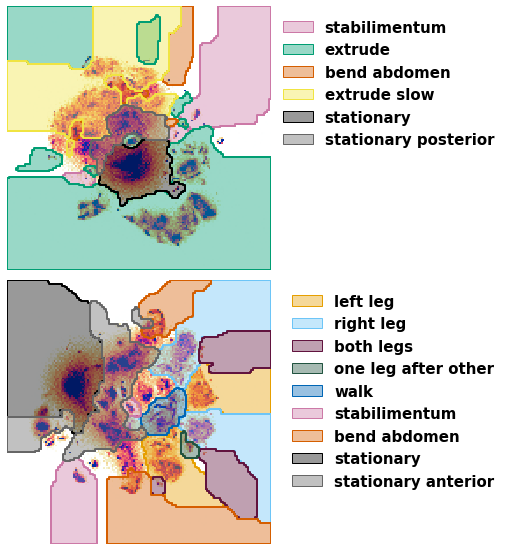

In [12]:
_cm = customColormap() # 'gray_r'

fig, ax = plt.subplots(2, 1, figsize=(16, 8))

def formatLabel(x):
    return x.replace('-', ' ')

for fnameIdx in range(2):
    # Get image
    imgDensity = np.clip(arrWatershed[fnameIdx][:,:,0,0], 0, 
        np.percentile(arrWatershed[fnameIdx][:,:,0,0], 99))
    
    # Plot density
    ax[fnameIdx].imshow(Hs[fnameIdx], cmap=_cm)

    for k, clusterIDsKey in enumerate([x for x in clusterLabels[fnameIdx] if False or x != 'noisy']):
        clusterIDs = clusterLabels[fnameIdx][clusterIDsKey]
        # Plot clusters to highlight
        mask = None
        for exID, clusterID in enumerate(clusterIDs):
            _mask = (arrWatershed[fnameIdx][:,:,0,1] == clusterID)
            # Merge masks
            mask = _mask if mask is None else (mask | _mask)

        # Split masks into contiguous submasks
        maskLabeled = label(ndimage.binary_dilation(ndimage.binary_erosion(mask, iterations=1), iterations=1))
        maskLabeledBg = np.max([np.sum(maskLabeled == x) for x in np.unique(maskLabeled)])
        isLabeled = False
        for z, maskID in enumerate(np.unique(maskLabeled)):
            if np.sum(maskLabeled == maskID) != maskLabeledBg:
                mask = (maskLabeled == maskID)
                mask[:25,:] = False
                mask[175:,:] = False
                mask[:,:25] = False
                mask[:,175:] = False
                pts = maskToPerimeter(mask)
                if pts is not None:
                    ax[fnameIdx].fill(pts[:,1], pts[:,0], linewidth=1, \
                        edgecolor=COLORS_CLUSTERS[clusterIDsKey], 
                        facecolor=COLORS_CLUSTERS[clusterIDsKey] + '66', 
                        label=formatLabel(clusterIDsKey) if not isLabeled else None)
                    ax[fnameIdx].plot(pts[:,1], pts[:,0], linewidth=2, \
                        color=COLORS_CLUSTERS[clusterIDsKey])
                    isLabeled = True

    # Finish first subplot
    ax[fnameIdx].legend(frameon=False, fontsize=15, bbox_to_anchor=(0,0,1.9,1))
    ax[fnameIdx].set_xlim(25, 175)
    ax[fnameIdx].set_ylim(25, 175)
    ax[fnameIdx].set_axis_off()
    
fig.tight_layout()

fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig_2g.pdf')